# Conformalized Survival Regression

In this notebook we'll explore survival prediction in a classical setting, survival prediction under incomplete censoring times, and our proposed remedy for incomplete censoring times, using our novel technique.

First we need a baseline. In the classical case of Type I censoring, for every patient there is a triplet $(X,C,T)$, of which we have access to $(X,\tilde{T}=C\wedge T, T)$.
We'll use the same random generation process as Candes et. al.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import sys
%matplotlib inline

from sklearn.model_selection import train_test_split
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.util import Surv
from sklearn.dummy import DummyRegressor



In [14]:
n_samples = 10000
X_uni = np.random.uniform(low=0.0, high=4.0, size=n_samples)
X_uni.sort()
X_multi = np.random.uniform(low=-1.0, high=1.0, size=(n_samples, 100))
C_uni = np.random.exponential(10, size=n_samples) * X_uni/2
C_multi = np.random.exponential(10, size=n_samples) * (X_multi[:,0] + 1) 
mu_uni = 2 + 0.37 * np.sqrt(X_uni)
sd_uni_homo = 1.5
sd_uni_hetero = 1 + X_uni/5

T_uni_homo = np.exp(np.random.normal(loc=mu_uni, scale=sd_uni_homo, size=n_samples))
T_tilde_uni_homo = Surv.from_arrays((T_uni_homo < C_uni), np.minimum(T_uni_homo, C_uni))
T_uni_hetero = np.exp(np.random.normal(loc=mu_uni, scale=sd_uni_hetero, size=n_samples))
T_tilde_uni_hetero = Surv.from_arrays((T_uni_hetero < C_uni), np.minimum(T_uni_hetero, C_uni))
T_tilde_uni_hetero = np.minimum(T_uni_hetero, C_uni)

mu_multi = np.log(2) + 1 + 0.55 * (X_multi[:,0]**2 + X_multi[:,2] * X_multi[:,4])
sd_multi_homo = 1
sd_multi_hetero = np.abs(X_multi[:,9]) + 1

T_multi_homo = np.exp(np.random.normal(loc=mu_multi, scale=sd_multi_homo, size=n_samples))
T_tilde_multi_homo = Surv.from_arrays((T_multi_homo < C_multi), np.minimum(T_multi_homo, C_multi))
T_multi_hetero = np.exp(np.random.normal(loc=mu_multi, scale=sd_multi_hetero, size=n_samples))
T_tilde_multi_hetero = Surv.from_arrays((T_multi_hetero < C_multi), np.minimum(T_multi_hetero, C_multi))

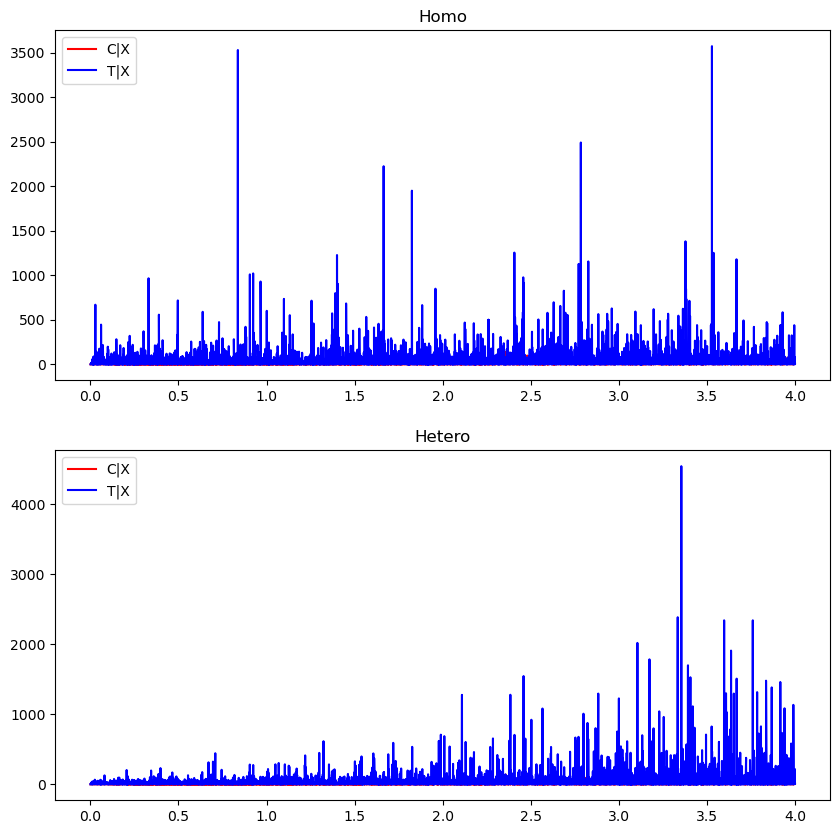

In [16]:
data_uncensored = [
    (X_uni, C_uni, T_uni_homo),
    (X_uni, C_uni, T_uni_hetero)
]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Flattening the axes array for easier iteration
axs = axs.flatten()

for i in range(2):
    x, c, t = data_uncensored[i]
    axs[i].plot(x, c, color="red", label='C|X', )
    axs[i].plot(x, t, color="blue", label='T|X')
    axs[i].legend(loc='upper left')

axs[0].set_title("Homo")
axs[1].set_title("Hetero")
plt.show()

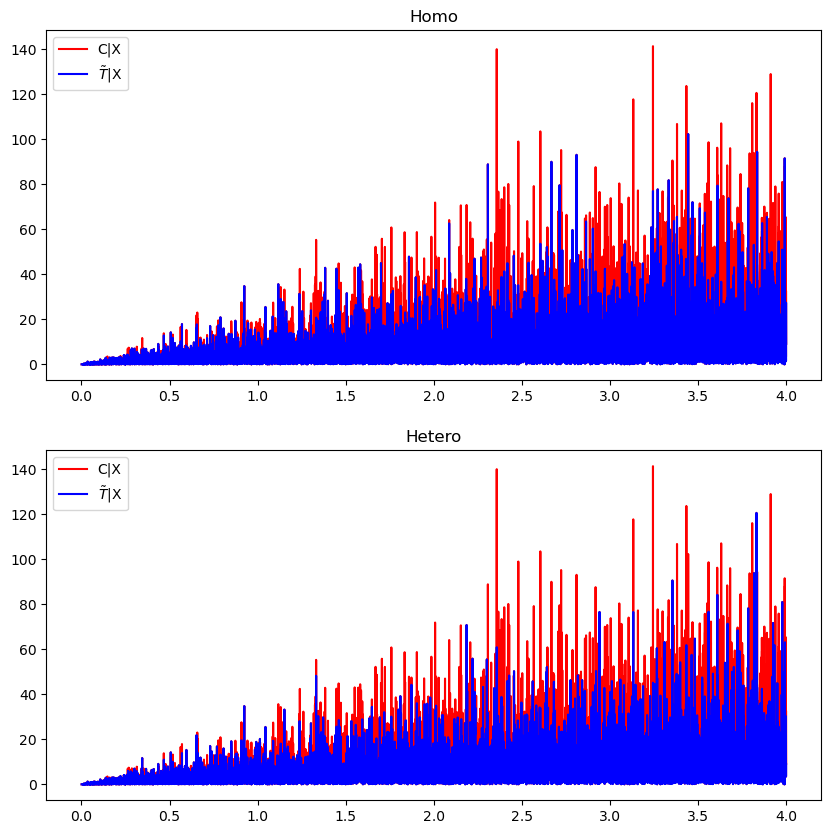

In [17]:
data_censored = [
    (X_uni, C_uni, np.minimum(T_uni_homo, C_uni)),
    (X_uni, C_uni, np.minimum(T_uni_hetero, C_uni))
]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Flattening the axes array for easier iteration
axs = axs.flatten()

for i in range(2):
    x, c, t = data_censored[i]
    axs[i].plot(x, c, color="red", label='C|X', )
    axs[i].plot(x, t, color="blue", label=r'$\tilde{T}$|X')
    axs[i].legend(loc='upper left')

axs[0].set_title("Homo")
axs[1].set_title("Hetero")
plt.show()

In [18]:
alpha = 0.1
betas = np.array([beta/10.0 for beta in range(1, 10, 1)])
X_uni_train, X_uni_test, C_train, C_test, T_uni_homo_train, T_uni_homo_test = train_test_split(X_uni, C_uni, T_tilde_uni_homo)
_, _, _, _,  T_uni_hetero_train, T_uni_hetero_test = train_test_split(X_uni, C_uni, T_tilde_uni_hetero)
X_multi_train, X_multi_test, _, _,  T_multi_hetero_train, T_multi_hetero_test = train_test_split(X_multi, C_multi, T_tilde_multi_hetero)
_, _, _, _,  T_multi_homo_train, T_multi_homo_test = train_test_split(X_multi, C_multi, T_tilde_multi_homo)

# Weighted Conformal

In [7]:
def non_conformity(y, y_hat):
    return y_hat - y["time"]

def estimate_weights(betas, C_hat, c_0):
    # Step 1: Find where C_hat > c_0
    greater_than_c0 = C_hat > c_0

    # Step 2: Find the index of the first True value in each row
    first_true_indices = (greater_than_c0.cumsum(axis=1) == 1).argmax(axis=1)

    # Step 3: Select the corresponding betas
    result = betas[first_true_indices]

    return 1.0/(1.0 - result)

# print(estimate_weights(np.array([0.1, 0.5 ,0.9]), np.array([[1, 2 ,3], [1, 3 ,5]]), 2.5)) # [10.  2.]

def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

[10.  2.]


In [26]:
def cfsurv_c0(X_train, X_test, C_train, T_tilde_train, c_0, alpha):   
    # split the train data into training and calibration
    C_train = C_train.astype([('event', '?'), ('time', '<f8')])
    T_tilde_train['time'] = np.minimum(T_tilde_train['time'], c_0)
    X_train, X_cal, C_train, C_cal, T_tilde_train, T_tilde_cal = train_test_split(X_train, C_train, T_tilde_train, train_size=X_train.shape[0]//2)
    
    # keep only data where C>=c_0
    T_cal_filtered = T_cal[T_cal['time'] >= c_0]
        
    # train a regression model on T: q_hat(x)
    T_est = GradientBoostingSurvivalAnalysis(loss="pinball", beta=1-alpha, learning_rate=0.1, max_depth=1, random_state=0)
    T_est.fit(X_train.reshape(-1,1), T_tilde_train)
    
    # compute conformity score for each point in the calibration set
    T_hat = T_est.predict(X_cal)
    scores = non_conformity(T_cal, T_hat)
    
    # estimate the weight for each point in the calibration set
    betas = np.array([beta/10.0 for beta in range(1, 10, 1)])
    C_est = [GradientBoostingSurvivalAnalysis(loss="pinball", beta=b, learning_rate=0.1, max_depth=1, random_state=0) for b in betas]
    C_hat_cal = []
    C_hat_test = []
    for est in C_est:
        C_est.fit(X_train.reshape(-1,1), C_train)
        C_hat_cal.append(C_est.predict(X_cal))
        C_hat_test.append(C_est.predict(X_test))
    
    w_cal = estimate_weights(betas, C_hat_cal, c_0)
    
    # compute the weights for the test data
    w_test = estimate_weights(betas, C_hat_test, c_0)
    
    # compute propensity scores
    p_test = w_test / (w_cal.sum() + w_test)
    p_cal = w_cal / (w_cal.sum() + w_cal)
    
    # compute LPB
    
    
    
    return LPB, emp_coverage, ...

In [103]:
# check splitting
X_train, X_cal, C_train, C_cal, T_train, T_cal = train_test_split(X_uni, C, T_tilde_uni_homo, train_size=X_uni.shape[0]//2)
print(X_uni.shape)
print(X_train.shape)
print(T_train.shape)
c_0 = 4
T_train_filtered = T_train[T_train['time'] >= c_0]

(10000,)
(5000,)
(5000,)


(1441,)

# Univariate Homoscedastic

In [23]:
T_uni_homo_est = GradientBoostingSurvivalAnalysis(loss="pinball", beta=1-alpha, learning_rate=0.1, max_depth=1, random_state=0)
T_uni_homo_est.fit(X_uni_train.reshape(-1,1), T_uni_homo_train)
C_uni_homo_est_dummy = [DummyRegressor(strategy="quantile", quantile=b) for b in betas]
for i, b in enumerate(betas):
    C_uni_homo_est_dummy[i].fit(X_uni_train.reshape(-1,1), C_train)

In [104]:
C_train_uncensored = C_train.copy().astype([('event', '?'), ('time', '<f8')])
C_train_uncensored[0]

(True, 0.28983493)

In [67]:
C_uni_homo_est = [GradientBoostingSurvivalAnalysis(loss="pinball", beta=b, learning_rate=0.1, max_depth=1, random_state=0) for b in betas]
for i, b in enumerate(betas):
    C_uni_homo_est[i].fit(X_uni_train.reshape(-1,1), C_train_uncensored)
    C_uni_homo_est[i].fit(X_uni_train.reshape(-1,1), C_train)